In [2]:
import blimpy
from blimpy import Waterfall
from blimpy import utils
from blimpy import plotting

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd
import glob

In [4]:
import turbo_seti.find_doppler.seti_event as turbo
import turbo_seti.find_event as find_event
from turbo_seti.find_doppler.find_doppler import FindDoppler
from turbo_seti.find_event.find_event_pipeline import find_event_pipeline
from turbo_seti.find_event.plot_event_pipeline import plot_event_pipeline
import pandas as pd
%matplotlib inline

print("All packages imported!")

All packages imported!


# Defining Functions

In [5]:
def grab_file_list(data_dir,file_type,node_number):
    '''
    returns h5 and dat file path from given directory, ordered correctly
    '''
    
    ## h5 list
    data_list = []
    for dirname, _, filenames in os.walk(data_dir):
        for filename in filenames:
            if filename[-len(file_type):] == file_type and node_number in filename:
                data_list.append(data_dir + filename)
                
    data_list = sorted(data_list, key=lambda x: (x,x.split('_')[5]))

    return data_list

In [6]:
def grab_file_path_all(data_dir,file_type):
    '''
    returns h5 and dat file path from given directory, ordered correctly
    '''
    
    ## h5 list
    data_list = []
    for dirname, _, filenames in os.walk(data_dir):
        for filename in filenames:
            if filename[-len(file_type):] == file_type:
                data_list.append(filename)
    
    data_list = sorted(data_list, key=lambda x: (x,x.split('_')[5]))
    # print(data_list)
    
    data_path = os.path.join(data_dir, file_type[1:]+'_list.lst')
    with open(data_path, 'w') as f:
        for path in data_list:
            f.write(data_dir+path + '\n')

    #You don't have to print, but it's a good way to check that your list is in the correct order:
    with open(data_path, 'r') as f:
        print(f.read())
    f.close()
    
    return data_path

In [7]:
def grab_file_path(data_dir,file_type,node_number):
    '''
    returns h5 and dat file path from given directory, ordered correctly
    '''
    
    ## h5 list
    data_list = []
    for dirname, _, filenames in os.walk(data_dir):
        for filename in filenames:
            if filename[-len(file_type):] == file_type and node_number in filename:
                data_list.append(filename)
    
    data_list = sorted(data_list, key=lambda x: (x,x.split('_')[5]))
    # print(data_list)
    
    data_path = os.path.join(data_dir, file_type[1:]+'_list.lst')
    with open(data_path, 'w') as f:
        for path in data_list:
            f.write(data_dir+path + '\n')

    #You don't have to print, but it's a good way to check that your list is in the correct order:
    with open(data_path, 'r') as f:
        print(f.read())
    f.close()
    
    return data_path

In [8]:
def files_plotter(files,f_start,f_end):
    '''
    Grabs the data of the waterfall object segment you are interested in
    '''

    this_cadence_data = []
    this_cadence_extents = []

    fig, axs = plt.subplots(len(files),figsize=(10, 1.5*len(files)))
    for file_number,file in enumerate(files):

    # print('getting data',file)
        obs = Waterfall(file,f_start=f_start,f_stop=f_end)
        #grab data
        data = obs.data
        plot_f, plot_data = obs.grab_data(f_start,f_end)
        plot_data = plot_data.astype('float32')
        # print('got data')
    
        #
        MAX_PLT_POINTS      = 65536                  # Max number of points in matplotlib plot
        MAX_IMSHOW_POINTS   = (8192, 4096)           # Max number of points in imshow plot
    
    
        dec_fac_x, dec_fac_y = 1, 1
        if plot_data.shape[0] > MAX_IMSHOW_POINTS[0]:
            dec_fac_x = int(plot_data.shape[0] / MAX_IMSHOW_POINTS[0])
    
        if plot_data.shape[1] > MAX_IMSHOW_POINTS[1]:
            dec_fac_y = int(plot_data.shape[1] / MAX_IMSHOW_POINTS[1])
            
        plot_data = utils.rebin(plot_data, dec_fac_x, dec_fac_y)
        extent = plotting.plot_utils.calc_extent(obs, plot_f=plot_f, plot_t=obs.timestamps, MJD_time=60098.829675925925)
        reverse=False
        if reverse==True:
                plot_data = plot_data[..., ::-1]  # Reverse data
                plot_f = plot_f[::-1]
        new_extent = list(extent)
        new_extent[2] = 0
        new_extent[3] = 292.057776
        new_extents = tuple(new_extent)

        axs[file_number].imshow(plot_data,
                       aspect='auto',
                       origin='lower',
                       rasterized=True,
                       interpolation='nearest',
                       extent = new_extents,
                       cmap='viridis',
                       )
        axs[file_number].set_xlabel("freq Mhz")
        axs[file_number].tick_params(axis='x', which='major', labelsize=1)
        axs[file_number].set_ylim( axs[file_number].get_ylim()[::-1])
        axs[file_number].tick_params(axis='y', which='major', labelsize=15)

        if file_number == 5:
            axs[file_number].tick_params(axis='x', which='major', labelsize=15)


    plt.subplots_adjust(hspace=0)
    plt.show()
    this_cadence_data.append(plot_data)
    this_cadence_extents.append(extent)


    return this_cadence_data, this_cadence_extents

In [8]:
os.getcwd()

'/datax/scratch/calebp'

In [9]:
def get_unique_nodes(data_dir):
    node_list = []
    for dirname, _, filenames in os.walk(data_dir):
        for filename in filenames:
            if "blc" in filename and (filename[4] != '7') and (filename[4] != '0'):
                node_list.append(filename[:5])

    node_set = set(node_list)
    print(node_set)

    unique_nodes = sorted(node_set)
    unique_nodes.sort()
    return unique_nodes

In [10]:
def wrapper(data_dir):
    
    # grab unique nodes
    node_list = []
    for dirname, _, filenames in os.walk(data_dir):
        for filename in filenames:
            if "blc" in filename and (filename[4] != '7') and (filename[4] != '0'):
                node_list.append(filename[:5])

    node_set = set(node_list)
    print(node_set)

    unique_nodes = sorted(node_set)
    unique_nodes.sort()
    
    print('unique',unique_nodes)
    
    
    # create a master csv where all hits will be stored

    master_csv = pd.DataFrame()
    
    # run find event on all nodes
    for i in unique_nodes:
        
        # try:
        # remove old csvs
        for csv_file in glob.iglob(os.path.join(data_dir, '*snr*.csv')):
            os.remove(csv_file)
        print(f"\n\n=================================NOW RUNNING {i}=========================")
        dat_list_path = grab_file_path(data_dir, '.dat',i)
        # print(dat_list_path)
        find_event_pipeline(dat_list_path, 
                filter_threshold = 3, 
                number_in_cadence = 6,
                sortby_tstart = False,
                saving=True)




        csv_file = glob.glob(data_dir+'*snr*.csv')
        print("CSV",csv_file)
        h5_list_path = grab_file_path(data_dir, '.h5',i)
        if len(csv_file) > 0:
            print("CSV FILE!")
            csv_file_path = csv_file[0]
            pd.set_option('display.max_colwidth', None)
            newest_csv = pd.read_csv(csv_file_path)
            if master_csv.empty:
                print("master empty")
                master_csv = newest_csv
                path =data_dir+"master.csv"
                master_csv.to_csv(path,index=False)
                
                
                master_csv_previous = pd.read_csv(data_dir+"master.csv")
                print("Master previous:", master_csv_previous)
                print("saving to:",path)
            else:
                print("master not empty")
                master_csv_previous = pd.read_csv(data_dir+"master.csv")

                print("Master previous:", master_csv_previous)
                concat = pd.concat([master_csv_previous, newest_csv])
                print('concat',concat)
                concat.to_csv(data_dir+"master.csv",index=False)
                print("saving to:",path)
            master_csv_after = pd.read_csv(data_dir+"master.csv")

            print("Master after:", master_csv_after)

            print(newest_csv.head())
            print(csv_file_path)
            # plot_event_pipeline(csv_file_path, # full path of the CSV file built by find_event_pipeline()',
            #     h5_list_path, # full path of text file containing the list of .h5 files
            #     filter_spec='f{}'.format(3), # filter threshold
            #     user_validation=False,
            #     plot_dir = data_dir+"plots/") # Non-interactive



In [52]:
# grab data from specific folder
def get_events(galaxy):
    
    
    data_dir = f"/mnt_blpc1/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/{galaxy}/"
    all_hits = pd.read_csv(data_dir+'master.csv')
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows',None)

In [12]:
test_run = ['HIP70497lband',
 'AND_II',
 'MESSIER101',
 'AND_X',
 'BOL520',
 'MESSIER86',
 'MESSIER87',
 'MESSIER59',
 'MESSIER60',
 'AND_I',
 'AND_XI',
 'AND_XIV',
 'AND_XVI',
 'AND_XXIII']
#'AND_XXIV', 'BOL520', 'CVNI', 'DDO210', 'DRACO', 'DW1', 'HERCULES', 'HIZSS003', 'IC0010', 'IC0342', 'IC1613',
run2 = ['AND_XXIV', 'BOL520', 'CVNI', 'DDO210', 'DRACO', 'DW1', 'HERCULES', 'HIZSS003', 'IC0010', 'IC0342', 'IC1613','LEOA', 'LEOII', 'LEOT', 'LGS3', 'MAFFEI1', 'MAFFEI2', 'MESSIER031', 'MESSIER033', 'MESSIER081', 'MESSIER101', 'MESSIER49', 'MESSIER59', 'MESSIER60', 'MESSIER84', 'MESSIER86', 'MESSIER87', 'NGC0185', 'NGC0628', 'NGC0672 ', 'NGC1052', 'NGC1172 ', 'NGC1400', 'NGC1407', 'NGC2403'] 
run3 = ['NGC2683', 'NGC2787', 'NGC3193', 'NGC3226', 'NGC3344', 'NGC3379', 'NGC4136', 'NGC4168', 'NGC4239', 'NGC4244', 'NGC4258', 'NGC4318', 'NGC4365', 'NGC4387', 'NGC4434', 'NGC4458', 'NGC4473', 'NGC4478', 'NGC4486B', 'NGC4489', 'NGC4551', 'NGC4559', 'NGC4564', 'NGC4600', 'NGC4618', 'NGC4660', 'NGC4736', 'NGC4826', 'NGC5194', 'NGC5195', 'NGC5322', 'NGC5638', 'NGC5813', 'NGC5831', 'NGC584', 'NGC5845', 'NGC5846', 'NGC596', 'NGC636', 'NGC6503', 'NGC6822', 'NGC6946', 'NGC720', 'NGC7454 ', 'NGC7640', 'NGC821', 'PEGASUS', 'SAG_DIR', 'SEXA', 'SEXB']
run3_unfinished = ['NGC4458', 'NGC4473', 'NGC4478', 'NGC4486B', 'NGC4489', 'NGC4551', 'NGC4559', 'NGC4564', 'NGC4600', 'NGC4618', 'NGC4660', 'NGC4736', 'NGC4826', 'NGC5194', 'NGC5195', 'NGC5322', 'NGC5638', 'NGC5813', 'NGC5831', 'NGC584', 'NGC5845', 'NGC5846', 'NGC596', 'NGC636', 'NGC6503', 'NGC6822', 'NGC6946', 'NGC720', 'NGC7454 ', 'NGC7640', 'NGC821', 'PEGASUS', 'SAG_DIR', 'SEXA', 'SEXB']
run4 = ['SEXDSPH', 'UGC04879', 'UGCA127', 'UMIN']

In [14]:
data_dir_1 = "/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/"
data_dir_2 = "/datax/scratch/calebp/seticore_testing/snr_testing/10off10on/"

In [16]:
for data_dir in [data_dir_1]:
    print(data_dir)
    for galaxy in run4:
        dir = data_dir + galaxy + "/"
        print(dir)
        wrapper(dir)

/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/SEXDSPH/
{'blc05', 'blc02', 'blc03', 'blc04', 'blc06', 'blc01'}
unique ['blc01', 'blc02', 'blc03', 'blc04', 'blc05', 'blc06']


=================================NOW RUNNING blc01=========================
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/SEXDSPH/blc01_guppi_59403_82364_SexDSph_0010.rawspec.0000.dat
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/SEXDSPH/blc01_guppi_59403_82685_HIP50385_0011.rawspec.0000.dat
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/SEXDSPH/blc01_guppi_59403_83006_SexDSph_0012.rawspec.0000.dat
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/SEXDSPH/blc01_guppi_59403_83330_HIP50558_0013.rawspec.0000.dat
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/SEXDSPH/blc01_guppi_59403_83654_SexDSph_0014.rawspec.0000.dat
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/SEX

In [15]:
def cycle_events(all_events,data_dir):
    '''
    Cycles through the hits of a given snr, plots them, and returns the events as np arrays 
    '''
    print('cycling!')
    all_plot_data = []
    all_extents = []
    all_file_names = []
    for i in range(0,len(all_events)):
        file = data_dir + all_events["FileID"][i]
        file = file[:-3]+"h5"
        drift_rate = all_events["DriftRate"][i]
        freq = all_events["Freq"][i]
        f_start = freq - (drift_rate/10**6)*2000
        f_end = freq + (drift_rate/10**6)*2000
    
    
        node = file.split("/")[-1][0:5]
        print(f"================================ {i} -- NODE {node} =============================")
        print("f_start,",f_start,"f_stop:",f_end,"file:",file)
              
        h5_list_path = grab_file_list(data_dir, '.h5',node)
        this_cadence_data = []
        this_cadence_extents = []
        all_file_names.append(h5_list_path)        
        # print(h5_list_path)
        this_cadence_data, this_cadence_extents = files_plotter(h5_list_path,f_start,f_end)


        all_plot_data.append(this_cadence_data)
        all_extents.append(this_cadence_extents)
    return all_plot_data, all_extents, all_file_names


In [136]:
full_csv = pd.read_csv('/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XXIII/master.csv')
temp_csv = full_csv[0:1]

In [162]:
print(temp_csv["FileID"].values[0][:5])

blc73


/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc73_guppi_58832_20115_And_XVI_0069.gpuspec.0000.h5
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc73_guppi_58832_20435_HIP5148_0070.gpuspec.0000.h5
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc73_guppi_58832_20755_And_XVI_0071.gpuspec.0000.h5
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc73_guppi_58832_21076_HIP4047_0072.gpuspec.0000.h5
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc73_guppi_58832_21397_And_XVI_0073.gpuspec.0000.h5
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc73_guppi_58832_21719_HIP4103_0074.gpuspec.0000.h5

plot_event_pipeline: Opened file /datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/temp.csv
plot_event_pipeline: file = blc73_guppi_58832_20115_And_XVI_0069.gpuspec.0000.h5, tstart = 58832.2328125, source_name = And_XVI
plot_event_pipeline: file = blc73_g

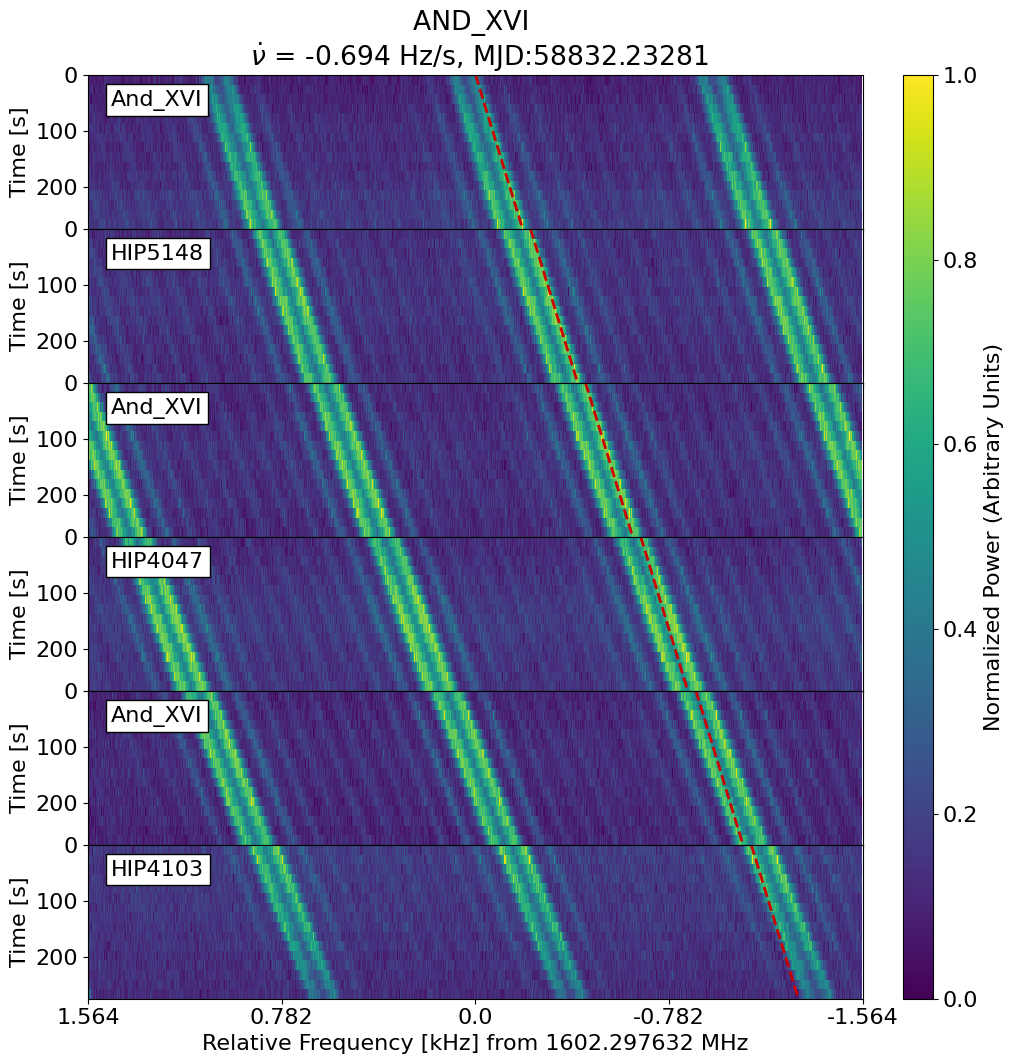

plot_event      INFO     plot_candidate_events: elapsed time = 8.47 seconds
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc73_guppi_58832_20115_And_XVI_0069.gpuspec.0000.h5
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc73_guppi_58832_20435_HIP5148_0070.gpuspec.0000.h5
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc73_guppi_58832_20755_And_XVI_0071.gpuspec.0000.h5
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc73_guppi_58832_21076_HIP4047_0072.gpuspec.0000.h5
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc73_guppi_58832_21397_And_XVI_0073.gpuspec.0000.h5
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc73_guppi_58832_21719_HIP4103_0074.gpuspec.0000.h5

plot_event_pipeline: Opened file /datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/temp.csv
plot_event_pipeline: file = blc73_guppi_58832_20115_And_XVI_0069.gpuspec.0000.h5, tstar

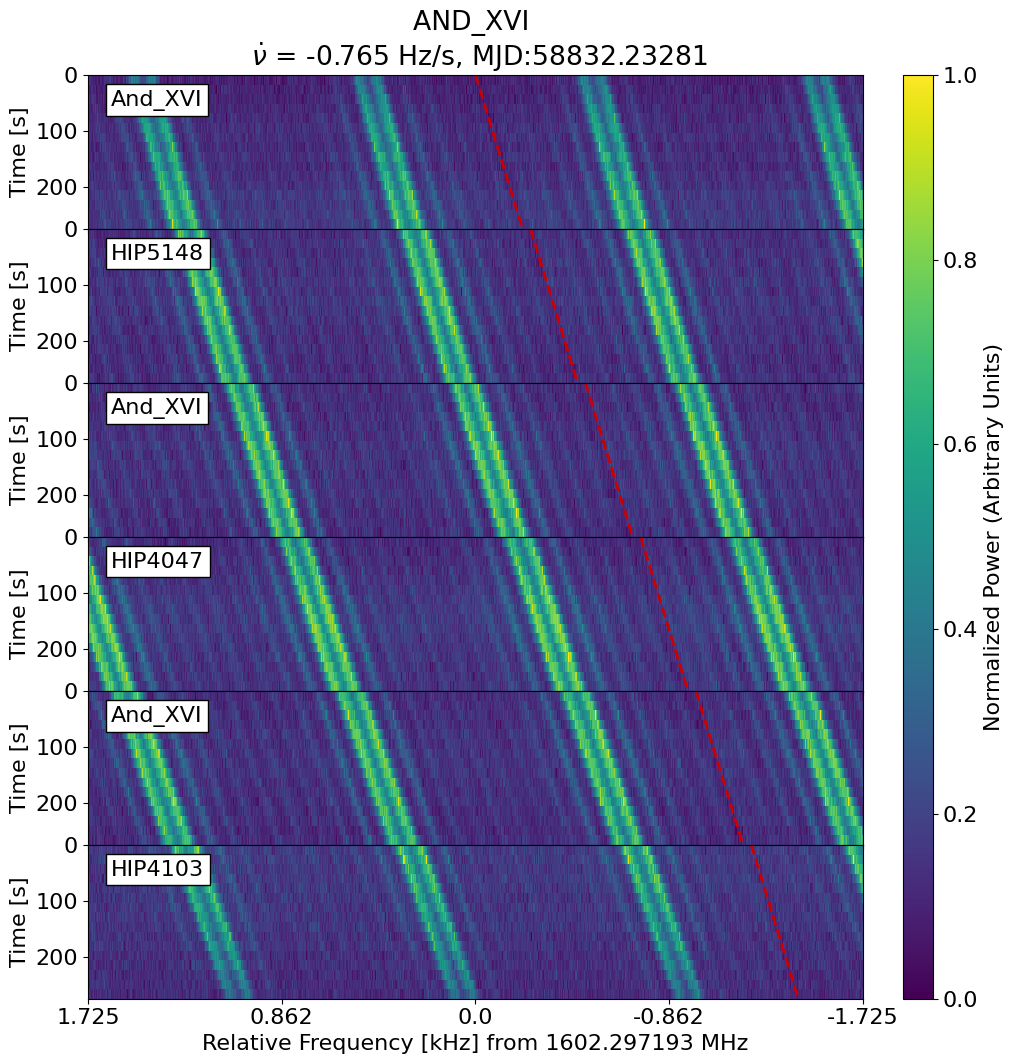

plot_event      INFO     plot_candidate_events: elapsed time = 9.75 seconds
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc73_guppi_58832_20115_And_XVI_0069.gpuspec.0000.h5
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc73_guppi_58832_20435_HIP5148_0070.gpuspec.0000.h5
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc73_guppi_58832_20755_And_XVI_0071.gpuspec.0000.h5
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc73_guppi_58832_21076_HIP4047_0072.gpuspec.0000.h5
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc73_guppi_58832_21397_And_XVI_0073.gpuspec.0000.h5
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc73_guppi_58832_21719_HIP4103_0074.gpuspec.0000.h5

plot_event_pipeline: Opened file /datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/temp.csv
plot_event_pipeline: file = blc73_guppi_58832_20115_And_XVI_0069.gpuspec.0000.h5, tstar

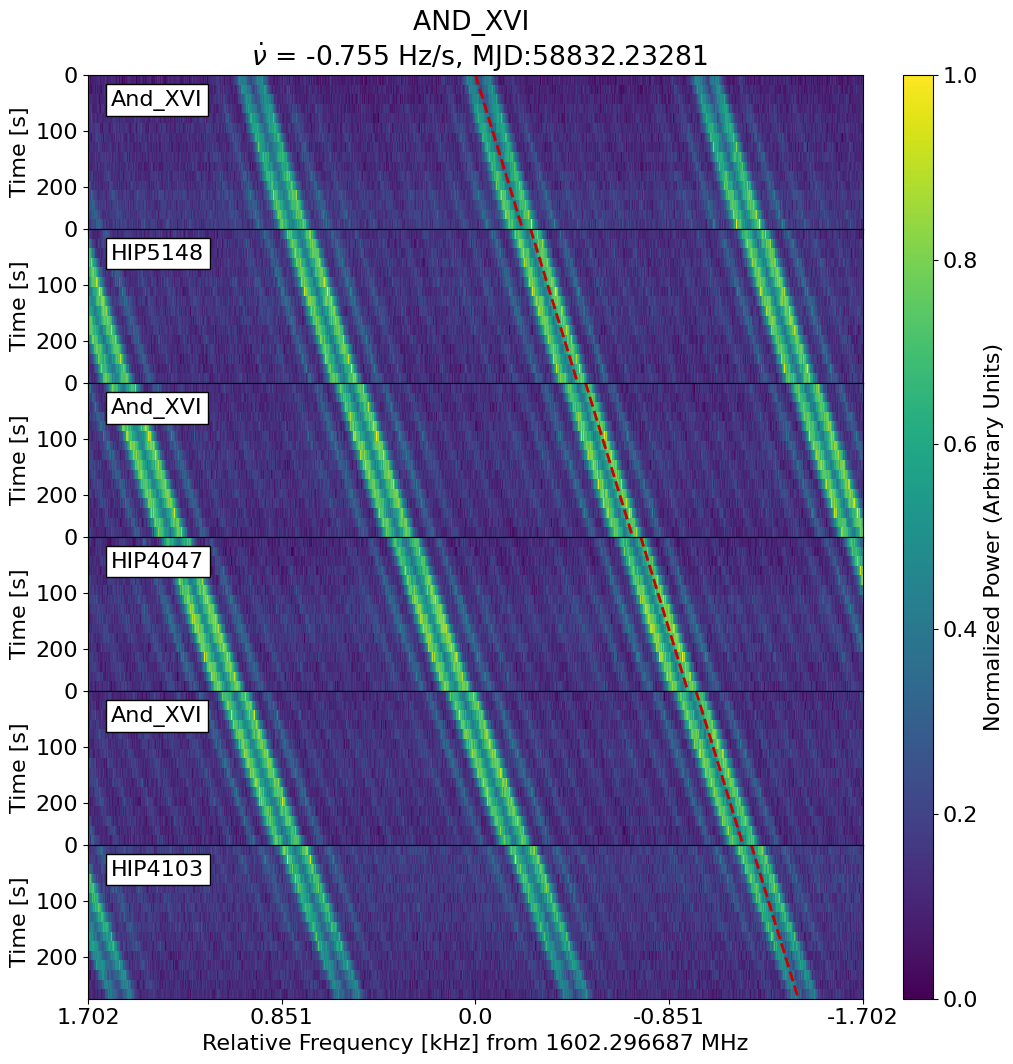

plot_event      INFO     plot_candidate_events: elapsed time = 10.21 seconds
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc75_guppi_58832_20115_And_XVI_0069.gpuspec.0000.h5
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc75_guppi_58832_20435_HIP5148_0070.gpuspec.0000.h5
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc75_guppi_58832_20755_And_XVI_0071.gpuspec.0000.h5
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc75_guppi_58832_21076_HIP4047_0072.gpuspec.0000.h5
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc75_guppi_58832_21397_And_XVI_0073.gpuspec.0000.h5
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc75_guppi_58832_21719_HIP4103_0074.gpuspec.0000.h5

plot_event_pipeline: Opened file /datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/temp.csv
plot_event_pipeline: file = blc75_guppi_58832_20115_And_XVI_0069.gpuspec.0000.h5, tsta

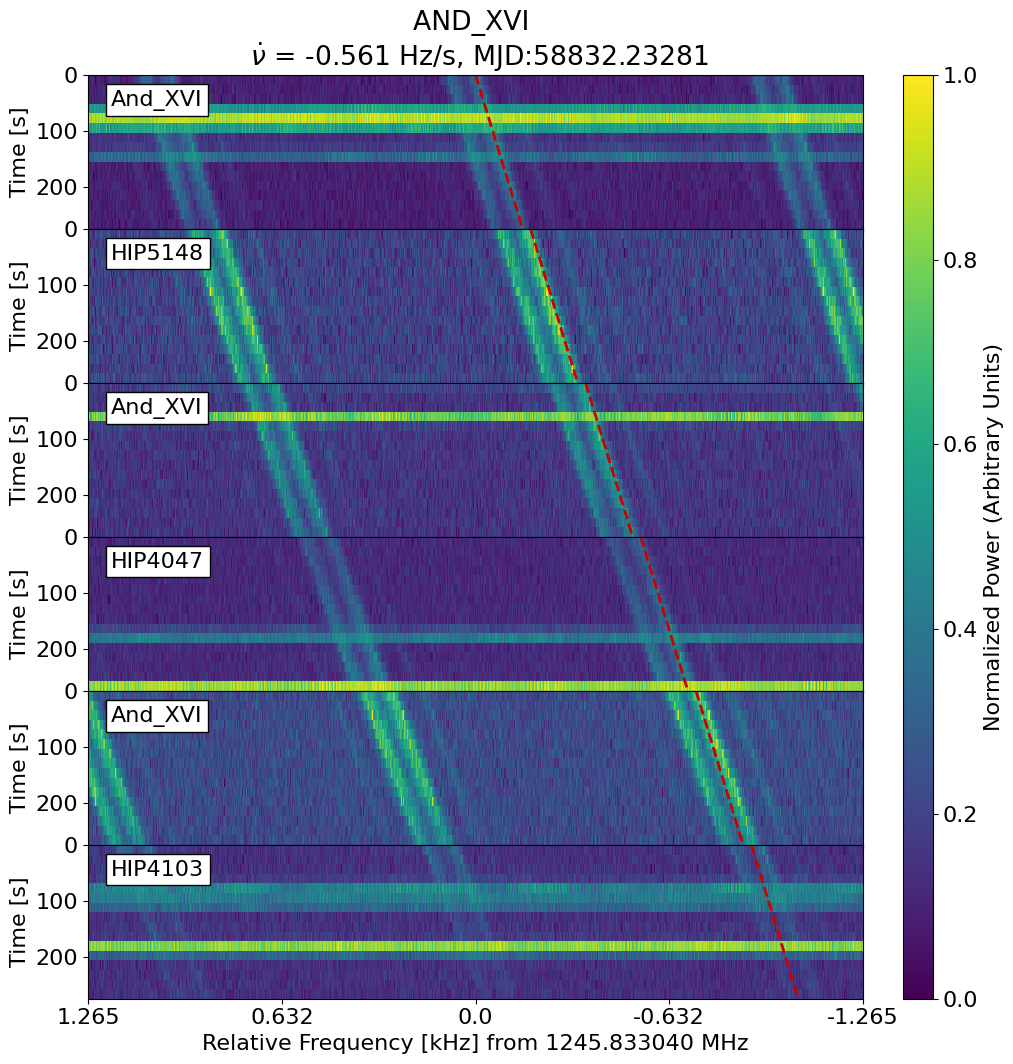

plot_event      INFO     plot_candidate_events: elapsed time = 20.17 seconds
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc75_guppi_58832_20115_And_XVI_0069.gpuspec.0000.h5
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc75_guppi_58832_20435_HIP5148_0070.gpuspec.0000.h5
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc75_guppi_58832_20755_And_XVI_0071.gpuspec.0000.h5
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc75_guppi_58832_21076_HIP4047_0072.gpuspec.0000.h5
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc75_guppi_58832_21397_And_XVI_0073.gpuspec.0000.h5
/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/blc75_guppi_58832_21719_HIP4103_0074.gpuspec.0000.h5

plot_event_pipeline: Opened file /datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XVI/temp.csv
plot_event_pipeline: file = blc75_guppi_58832_20115_And_XVI_0069.gpuspec.0000.h5, tsta

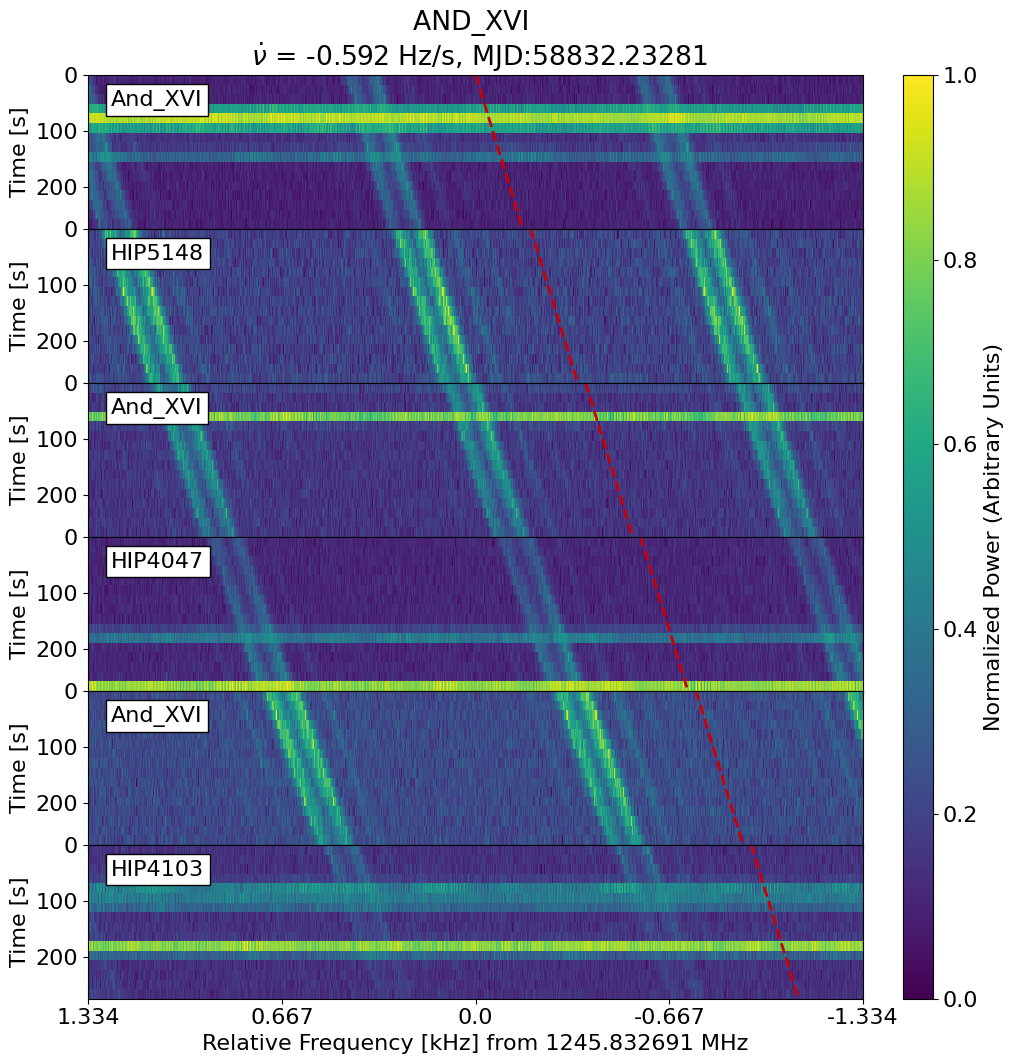

plot_event      INFO     plot_candidate_events: elapsed time = 8.14 seconds


In [163]:
# check that master saves events in readable format
source = "AND_XVI"
data_dir = f'/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/{source}/'
full_csv = pd.read_csv(data_dir+'master.csv')
for i in range(1,len(full_csv)):
    temp_csv = full_csv[i-1:i]
    temp_csv.to_csv(data_dir+'temp.csv')
    node = temp_csv["FileID"].values[0][:5]
    
    h5_list_path = grab_file_path(data_dir, '.h5',node)
    csv_file = glob.glob(data_dir+'*p.csv')
    
    plot_event_pipeline(csv_file[0], # full path of the CSV file built by find_event_pipeline()',
                h5_list_path, # full path of text file containing the list of .h5 files
                filter_spec='f{}'.format(3), # filter threshold
                user_validation=False,
                plot_dir = data_dir+"plots/") # Non-interactive

In [33]:
len(pd.read_csv("/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/AND_XXIII/master.csv")

6

In [17]:
test_run2 = ['HIP70497lband',
 'AND_II',
 'MESSIER101',
 'AND_X',
 'BOL520',
 'MESSIER86',
 'MESSIER87',
 'MESSIER59',
 'MESSIER60',
 'AND_I',
 'AND_XI',
 'AND_XIV',
 'AND_XVI',
 'AND_XXIII','AND_XXIV', 'BOL520', 'CVNI', 'DDO210', 'DRACO', 'DW1', 'HERCULES', 'HIZSS003', 'IC0010', 'IC0342', 'IC1613','LEOA', 'LEOII', 'LEOT', 'LGS3', 'MAFFEI1', 'MAFFEI2', 'MESSIER031', 'MESSIER033', 'MESSIER081', 'MESSIER101', 'MESSIER49', 'MESSIER59', 'MESSIER60', 'MESSIER84', 'MESSIER86', 'MESSIER87', 'NGC0185', 'NGC0628', 'NGC0672 ', 'NGC1052',
             'NGC1172 ', 'NGC1400', 'NGC1407', 'NGC2403'] 

# final_test_run = 

In [18]:
def grab_events_numbers(snr):
    '''
    Combines all L band events into one csv file
    '''
    all_events_csv =pd.DataFrame()
    all_events_csv.to_csv(f"/datax/scratch/calebp/seticore_testing/snr_testing/{snr}off10on/all_events.csv",index=False)
    for galaxy in test_run2:
        try:
            galaxy_csv = pd.read_csv(f"/datax/scratch/calebp/seticore_testing/snr_testing/{snr}off10on/{galaxy}/master.csv")
            # cycle_events(galaxy_csv,f"/datax/scratch/calebp/seticore_testing/snr_testing/{snr}off10on/{galaxy}/")
            if all_events_csv.empty:
                all_events_csv=galaxy_csv
                all_events_csv.to_csv(f"/datax/scratch/calebp/seticore_testing/snr_testing/{snr}off10on/all_events.csv",index=False)
            else:
                all_events_csv = pd.read_csv(f"/datax/scratch/calebp/seticore_testing/snr_testing/{snr}off10on/all_events.csv")
                concat = pd.concat([all_events_csv, galaxy_csv])
                concat.to_csv(f"/datax/scratch/calebp/seticore_testing/snr_testing/{snr}off10on/all_events.csv",index=False)
            print(f"cycled galaxy {galaxy}")
        except:
            print(f"no events for galaxy {galaxy}")
    all_events_csv = pd.read_csv(f"/datax/scratch/calebp/seticore_testing/snr_testing/{snr}off10on/all_events.csv")
    return all_events_csv
    # print(all_events_csv)


no events for galaxy HIP70497lband
cycled galaxy AND_II
cycled galaxy MESSIER101
no events for galaxy AND_X
no events for galaxy BOL520
no events for galaxy MESSIER86
no events for galaxy MESSIER87
no events for galaxy MESSIER59
cycled galaxy MESSIER60
cycled galaxy AND_I
cycled galaxy AND_XI
cycled galaxy AND_XIV
cycled galaxy AND_XVI
cycled galaxy AND_XXIII
cycled galaxy AND_XXIV
no events for galaxy BOL520
cycled galaxy CVNI
cycled galaxy DDO210
cycled galaxy DRACO
cycled galaxy DW1
cycled galaxy HERCULES
no events for galaxy HIZSS003
cycled galaxy IC0010
cycled galaxy IC0342
cycled galaxy IC1613
no events for galaxy LEOA
cycled galaxy LEOII
cycled galaxy LEOT
no events for galaxy LGS3
cycled galaxy MAFFEI1
no events for galaxy MAFFEI2
no events for galaxy MESSIER031
cycled galaxy MESSIER033
cycled galaxy MESSIER081
cycled galaxy MESSIER101
cycled galaxy MESSIER49
no events for galaxy MESSIER59
cycled galaxy MESSIER60
no events for galaxy MESSIER84
no events for galaxy MESSIER86
no 

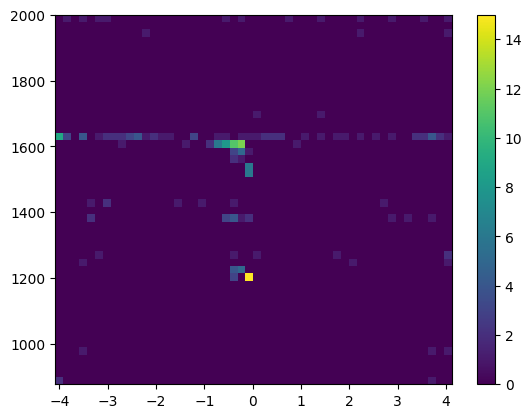

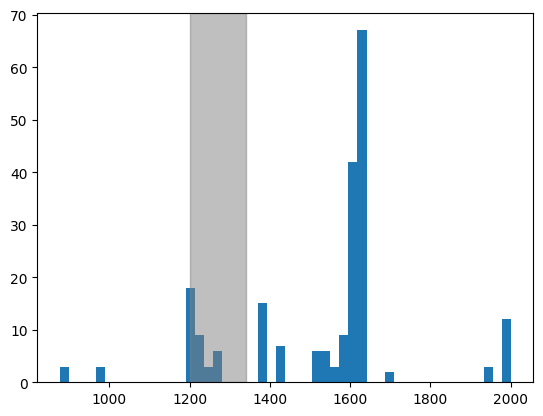

cycled galaxy HIP70497lband
cycled galaxy AND_II
cycled galaxy MESSIER101
no events for galaxy AND_X
no events for galaxy BOL520
cycled galaxy MESSIER86
no events for galaxy MESSIER87
no events for galaxy MESSIER59
cycled galaxy MESSIER60
cycled galaxy AND_I
cycled galaxy AND_XI
cycled galaxy AND_XIV
cycled galaxy AND_XVI
cycled galaxy AND_XXIII
cycled galaxy AND_XXIV
no events for galaxy BOL520
cycled galaxy CVNI
cycled galaxy DDO210
cycled galaxy DRACO
cycled galaxy DW1
cycled galaxy HERCULES
no events for galaxy HIZSS003
cycled galaxy IC0010
cycled galaxy IC0342
cycled galaxy IC1613
no events for galaxy LEOA
cycled galaxy LEOII
cycled galaxy LEOT
no events for galaxy LGS3
cycled galaxy MAFFEI1
cycled galaxy MAFFEI2
cycled galaxy MESSIER031
cycled galaxy MESSIER033
cycled galaxy MESSIER081
cycled galaxy MESSIER101
cycled galaxy MESSIER49
no events for galaxy MESSIER59
cycled galaxy MESSIER60
cycled galaxy MESSIER84
cycled galaxy MESSIER86
no events for galaxy MESSIER87
cycled galaxy 

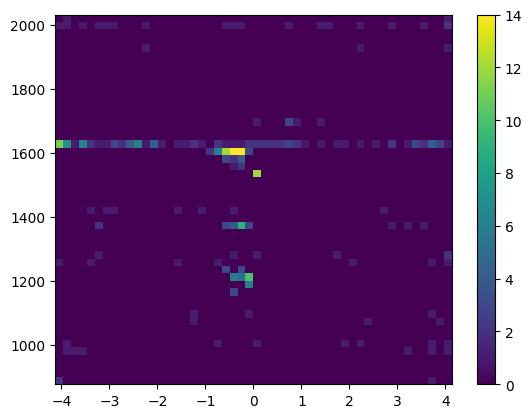

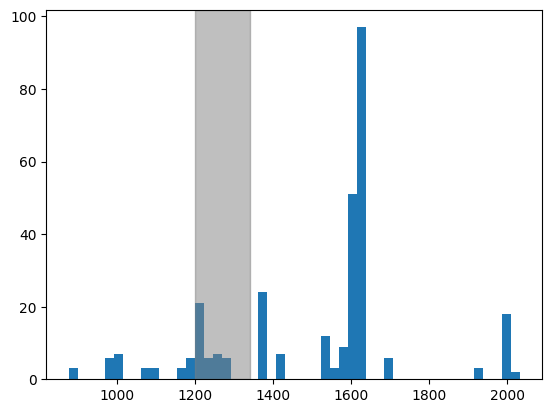

no events for galaxy HIP70497lband
cycled galaxy AND_II
cycled galaxy MESSIER101
cycled galaxy AND_X
cycled galaxy BOL520
cycled galaxy MESSIER86
no events for galaxy MESSIER87
no events for galaxy MESSIER59
cycled galaxy MESSIER60
cycled galaxy AND_I
cycled galaxy AND_XI
cycled galaxy AND_XIV
cycled galaxy AND_XVI
cycled galaxy AND_XXIII
cycled galaxy AND_XXIV
cycled galaxy BOL520
cycled galaxy CVNI
cycled galaxy DDO210
cycled galaxy DRACO
cycled galaxy DW1
cycled galaxy HERCULES
cycled galaxy HIZSS003
cycled galaxy IC0010
cycled galaxy IC0342
cycled galaxy IC1613
no events for galaxy LEOA
cycled galaxy LEOII
cycled galaxy LEOT
no events for galaxy LGS3
cycled galaxy MAFFEI1
cycled galaxy MAFFEI2
cycled galaxy MESSIER031
cycled galaxy MESSIER033
cycled galaxy MESSIER081
cycled galaxy MESSIER101
cycled galaxy MESSIER49
no events for galaxy MESSIER59
cycled galaxy MESSIER60
cycled galaxy MESSIER84
cycled galaxy MESSIER86
no events for galaxy MESSIER87
cycled galaxy NGC0185
cycled galaxy

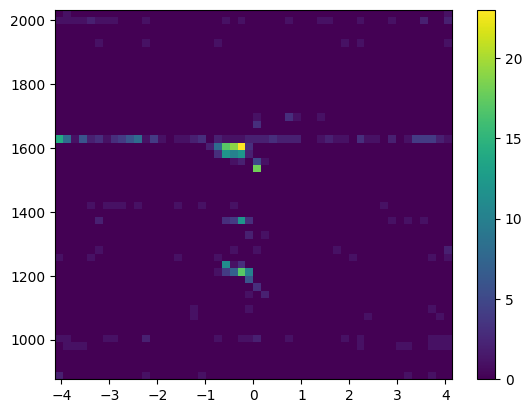

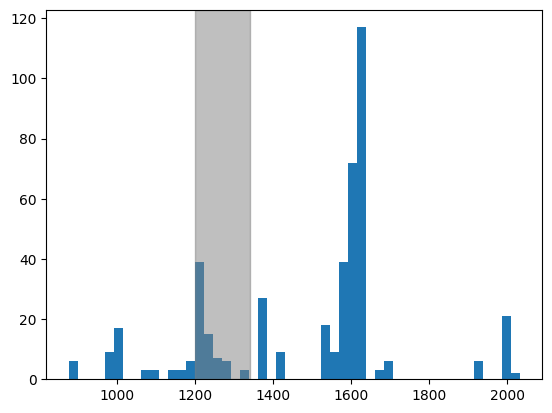

In [27]:
for i in [5,8,10]:
    all_events_csv = grab_events_numbers(i)
    # print(all_events_csv["Freq"], all_events_csv["DriftRate"])
    # print(all_events_csv)
    x= "DriftRate"
    y="Freq"
    # if i == 5:
    #     plt.hist(all_events_csv[y],color='red',label="SNR-OFF=5",alpha=1)
    # if i == 8:
    #     plt.hist(all_events_csv[y],color='green',label="SNR-OFF=8",alpha=.7)
    # if i == 10:
    #     plt.hist(all_events_csv[y],color='blue',label="SNR-OFF=10",alpha=.3)



    # plt.xlabel(y)
    # # plt.ylabel(y)
    # plt.legend()
    plt.hist2d(all_events_csv[x],all_events_csv[y],bins=50)
    plt.colorbar()
    plt.show()
    plt.hist(all_events_csv[y],bins=50)
    plt.axvspan(1200,1340,color='grey',alpha=.5)

    plt.show()
    # plt.hist(all_events_csv[y], bins=50)
    # # plt.axvspan(1560,1630,color='yellow',alpha=.5)

    # plt.xlabel("freq")
plt.show()


# Comparing Off SNRs

In [ ]:
def grab_hits_numbers(snr):
    all_hits = pd.read_csv(f"/datax/scratch/calebp/seticore_testing/snr_testing/{snr}off10on/all_dats.csv")
    return all_hits
    # print(all_events_csv)


In [38]:
def format_dats(num):
    all_dats = grab_hits_numbers(num)
    all_datsvalues = all_dats.values.tolist()
    all_datslist = [i[0] for i in all_datsvalues]
    return all_datslist

In [39]:
all_dats_5 = format_dats(5)
all_dats_8 = format_dats(8)
all_dats_10 = format_dats(10)

In [43]:
len(all_dats_10)

3593

In [49]:
common = list(set(all_dats_5).intersection(all_dats_8))

In [1]:
common[0:4]

NameError: name 'common' is not defined

In [ ]:
def get_all_hits(snr):
    '''
    Get all hits from a certain snr by merging all galaxy hits
    '''
    all_dats_short = pd.DataFrame()
    length = len(common)
    for row,i in enumerate(common[0:10]):
        print(f"{np.round(row/length,2)}\%", end="")
        dat_list = pd.read_csv(data_dir_1+i,skiprows=7,delim_whitespace=True)
        all_dats_short = pd.concat([all_dats_short,dat_list],ignore_index=True)
    

0.0\%0.0\%0.0\%0.0\%0.0\%0.0\%0.0\%0.0\%0.0\%0.0\%

In [ ]:
all_dats_short

,#,Top_Hit_#,Drift_Rate,SNR,Uncorrected_Frequency,Corrected_Frequency,Index,freq_start,freq_end,SEFD,SEFD_freq,Coarse_Channel_Number,Full_number_of_hits
0,#,--------------------------,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.010204,13.659624,1687.521662,1687.521662,516535.0,1687.521662,1687.521662,0.0,0.0,0.0,1.0,NaN
2,2,0.010204,12.806965,1687.454606,1687.454606,540535.0,1687.454606,1687.454606,0.0,0.0,0.0,1.0,NaN
3,3,-0.000000,10.788629,1681.526447,1681.526447,565154.0,1681.526447,1681.526447,0.0,0.0,2.0,1.0,NaN
4,4,-0.000000,9.130592,1681.512653,1681.512653,570091.0,1681.512653,1681.512653,0.0,0.0,2.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20554,144,0.010204,17.347643,1374.980531,1374.980531,181731.0,1374.980531,1374.980531,0.0,0.0,43.0,1.0,NaN
20555,145,-0.010204,21.670576,1374.961420,1374.961420,188571.0,1374.961420,1374.961420,0.0,0.0,43.0,1.0,NaN
20556,146,-0.877566,11.559230,1360.251353,1360.251353,210629.0,1360.251353,1360.251353,0.0,0.0,48.0,1.0,NaN
20557,147,-0.010204,33.547226,1349.993896,1349.993896,736188.0,1349.993896,1349.993896,0.0,0.0,51.0,1.0,NaN


In [ ]:
all_hits_10 = pd.read_csv(f"/datax/scratch/calebp/seticore_testing/snr_testing/10off10on/all_hits.csv")
all_hits_10 = trim(all_hits_10)


In [ ]:
all_hits_8 = pd.read_csv(f"/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/all_hits.csv")
all_hits_8 = trim(all_hits_8)


In [ ]:
all_hits_8

,#,Top_Hit_#,Drift_Rate,SNR,Uncorrected_Frequency,Corrected_Frequency,Index,freq_start,freq_end,SEFD,SEFD_freq,Coarse_Channel_Number,Full_number_of_hits
0,#,--------------------------,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,-0.000000,1319.310181,2062.500176,2062.500176,524225.0,2062.500176,2062.500176,0.0,0.0,0.0,1.0,NaN
2,2,-0.040817,11.139020,2062.466947,2062.466947,536118.0,2062.466947,2062.466947,0.0,0.0,0.0,1.0,NaN
3,3,-0.030613,11.412313,2062.453975,2062.453975,540761.0,2062.453975,2062.453975,0.0,0.0,0.0,1.0,NaN
4,4,-0.000000,63.046955,2050.000001,2050.000001,803908.0,2050.000001,2050.000001,0.0,0.0,4.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4707520,35,-0.030613,11.546705,1359.460490,1359.460490,493690.0,1359.460490,1359.460490,0.0,0.0,48.0,1.0,NaN
4707521,36,-0.000000,14.170513,1350.000001,1350.000001,734003.0,1350.000001,1350.000001,0.0,0.0,51.0,1.0,NaN
4707522,37,-0.000000,49.352661,1324.974923,1324.974923,253643.0,1324.974923,1324.974923,0.0,0.0,60.0,1.0,NaN
4707523,38,-0.000000,11.107776,1320.150043,1320.150043,931959.0,1320.150043,1320.150043,0.0,0.0,61.0,1.0,NaN


In [ ]:
def trim(all_hits):
    all_hits = all_hits.drop(columns=['Full_number_of_hits'])
    all_hits = all_hits.rename(columns={"#": "Top_Hit_#", "Top_Hit_#": "Drift_Rate","Drift_Rate": "SNR", "SNR": "Uncorrected_Frequency","Uncorrected_Frequency": "Corrected_Frequency", "Corrected_Frequency": "Index","Index": "freq_start", "freq_start": "freq_end", "freq_end": "Unused"})
    all_hits = all_hits.tail(-1)
    all_hits = all_hits.dropna()
    return all_hits

In [ ]:
import matplotlib as mpl
import matplotlib.pylab as plt

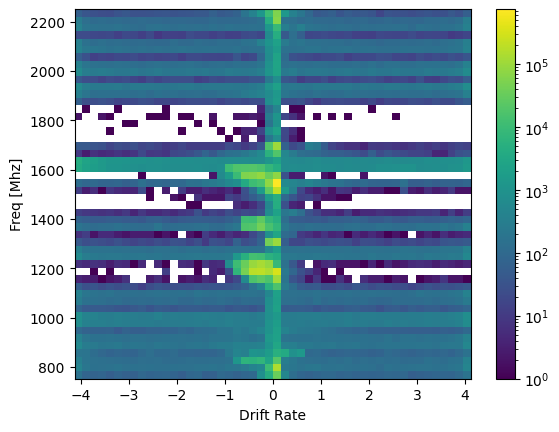

Text(0.5, 0, 'Drift Rate')

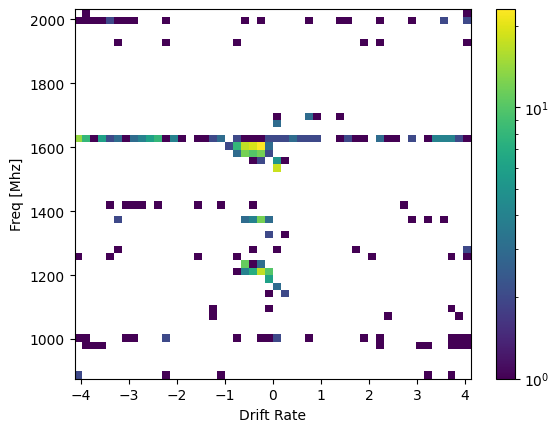

In [ ]:
drift10 = np.array(all_hits_10["Drift_Rate"], dtype=float)

plt.hist2d(drift10,all_hits_10["Uncorrected_Frequency"],bins=50,norm=mpl.colors.LogNorm())
plt.ylabel("Freq [Mhz]")
plt.xlabel("Drift Rate")

plt.colorbar()
plt.show()
plt.hist2d(all_events_10["DriftRate"],all_events_10["Freq"],bins=50,norm=mpl.colors.LogNorm())
plt.colorbar()
plt.ylabel("Freq [Mhz]")
plt.xlabel("Drift Rate")



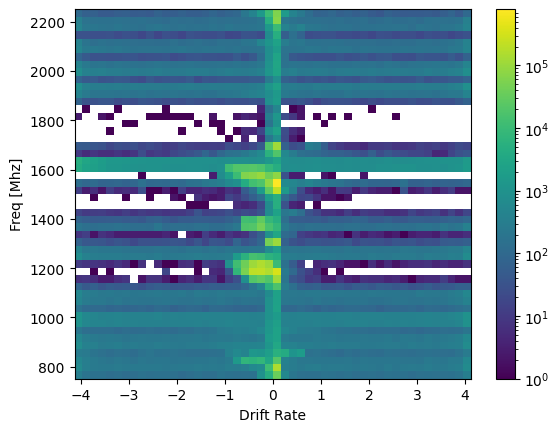

Text(0.5, 0, 'Drift Rate')

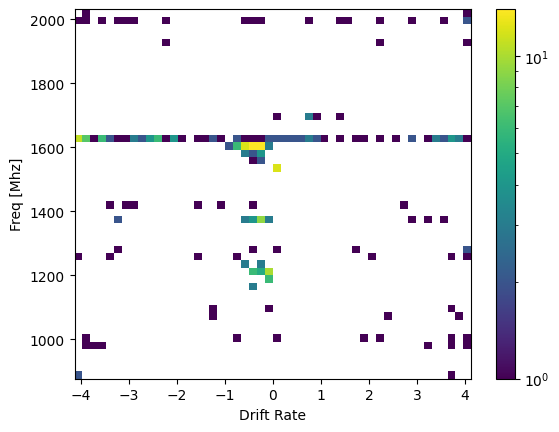

In [ ]:
drift8 = np.array(all_hits_8["Drift_Rate"], dtype=float)
plt.hist2d(drift8,all_hits_8["Uncorrected_Frequency"],bins=50,norm=mpl.colors.LogNorm())
plt.colorbar()
plt.ylabel("Freq [Mhz]")
plt.xlabel("Drift Rate")


plt.show()
plt.hist2d(all_events_8["DriftRate"],all_events_8["Freq"],bins=50,norm=mpl.colors.LogNorm())
plt.colorbar()
plt.ylabel("Freq [Mhz]")
plt.xlabel("Drift Rate")



In [ ]:
all_events_10 = pd.read_csv(f"/datax/scratch/calebp/seticore_testing/snr_testing/10off10on/all_events.csv")

In [ ]:
all_events_8 = pd.read_csv(f"/datax/scratch/calebp/seticore_testing/snr_testing/8off10on/all_events.csv")

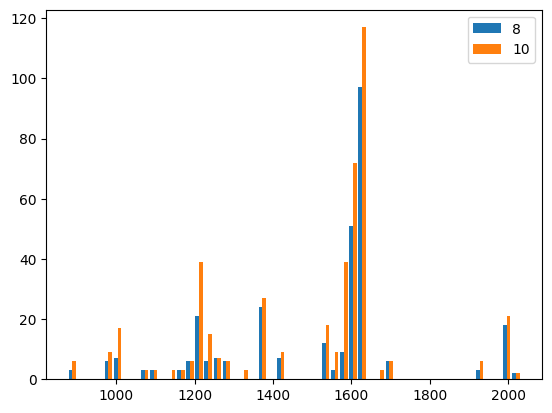

In [ ]:
plt.hist([all_events_8["Freq"], all_events_10["Freq"]], bins=50, label=['8', '10'])
plt.legend(loc='upper right')
plt.show()
